# Triton

In [1]:
!uv pip install triton --system

Using Python 3.11.11 environment at /usr
Audited 1 package in 286ms


In [2]:
import torch
import triton
import triton.language as tl

In [5]:
DEVICE = torch.device("cuda:0")

In [6]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements,
               BLOCK_SIZE: tl.constexpr):
  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offsets < n_elements
  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)
  output = x+y

  tl.store(output_ptr + offsets, output, mask=mask)

In [7]:
def add(x: torch.Tensor, y: torch.Tensor):
  output = torch.empty_like(x)
  assert x.device==DEVICE and y.device==DEVICE and output.device==DEVICE
  n_elements = output.numel()

  grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

  add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

  return output

In [8]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

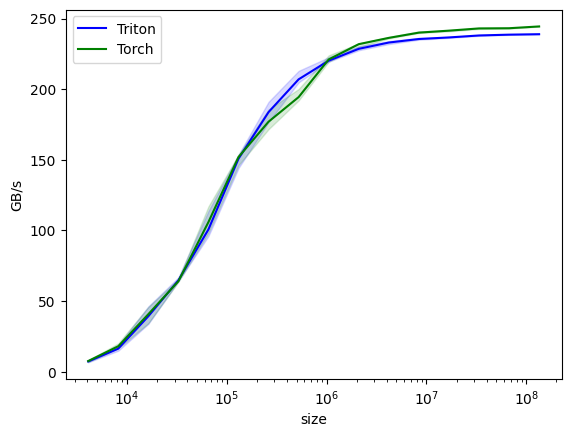

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.245283    7.566502
1        8192.0   16.340425   18.017595
2       16384.0   39.258786   40.688742
3       32768.0   64.673682   63.999998
4       65536.0  100.721313  105.931032
5      131072.0  150.773002  151.938181
6      262144.0  183.745795  176.964903
7      524288.0  206.955786  194.372710
8     1048576.0  220.165736  221.032035
9     2097152.0  228.547522  231.849058
10    4194304.0  232.999636  236.307695
11    8388608.0  235.493941  240.012805
12   16777216.0  236.609846  241.412683
13   33554432.0  237.997193  242.988407
14   67108864.0  238.578182  243.124568
15  134217728.0  238.899232  244.390085


In [10]:
benchmark.run(print_data=True, show_plots=True)